In [1]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf

OmegaConf.register_new_resolver(
    "relpath", lambda p: str(Path('/disk/scratch/nkudryas/BAND-torch/notebooks/').parent / p)
)

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "0"
os.environ["TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD"]= "1" # backward compatibility

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import h5py
from sklearn.linear_model import Ridge 
from sklearn.decomposition import PCA

from lfads_torch.metrics import r2_score, r2_UIVE

from goodman_panels import panels, panel_specs, label_panel, label_panels

from matplotlib import rcParams
cm = 1/2.54  # centimeters in inches

rcParams["figure.dpi"] = 300
rcParams["savefig.dpi"] = 300
rcParams["font.size"] = 7


In [3]:
dataset_name = 'chewie_10_07_mov'
# model_str='kl1_gauss_bd05'
model_str='kl1_gauss_bd_d20_causal_ci'
# model_str='kl1_gauss_causal_nosplit'

bin_size_ms = 10

N_FOLDS = 5

In [4]:
models_dest = f"/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/{dataset_name}"

fac_dim, co_dim = 100,4
bw = 0.1
encod_seq_len = 99 #101
encod_data_dim = 207
seed = 2
model_names = [f'{model_name}_both_{fac_dim}f_{co_dim}c_{model_str}' for model_name in ['lfads','band']]
model_dests = [[f"{models_dest}_cv{cv}/{model_name}" for cv in range(N_FOLDS)] for model_name in model_names]

model_dests


[['/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv0/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv1/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv2/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv3/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv4/lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci'],
 ['/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv0/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv1/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci',
  '/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv2/band_both_100f_4c_kl1_gau

In [5]:
import lfads_torch
import torch
from hydra.utils import instantiate
from pathlib import Path
import hydra

from lfads_torch.band_utils import flatten

models = []
for fold in range(N_FOLDS):

    overrides={
            "datamodule": dataset_name.split('_cv')[0],
            "datamodule.fold": fold,
            "model": model_str, # older models were run with list of beh decoders
            "model.encod_seq_len": encod_seq_len,
            "model.recon_seq_len": encod_seq_len,
            "model.kl_co_scale": float(encod_seq_len),
            "model.fac_dim": fac_dim,
            "model.co_dim": co_dim,
            "model.encod_data_dim": encod_data_dim,
            # "model.behavior_weight": bw,
        }
    # config_path="../../configs/pbt.yaml"
    config_path="../../configs/single.yaml"
    print(config_path)

    # Compose the train config with properly formatted overrides
    config_path = Path(config_path)
    overrides = [f"{k}={v}" for k, v in flatten(overrides).items()]
    with hydra.initialize(
        config_path=config_path.parent,
        job_name="get_weights",
        version_base="1.1",
    ):
        config = hydra.compose(config_name=config_path.name, overrides=overrides)

    # Instantiate `LightningDataModule` and `LightningModule`
    datamodule = instantiate(config.datamodule, _convert_="all")
    model = instantiate(config.model)

    from glob import glob
    checkpoint_folders = glob(model_dests[-1][fold]+'/best_model/checkpoint*')

    print(model_dests[-1][fold])

    # ckpt_path = checkpoint_folders[-1] + '/tune.ckpt'
    ckpt_path = f'{model_dests[-1][fold]}/lightning_checkpoints/last.ckpt'
    model.load_state_dict(torch.load(ckpt_path)["state_dict"])

    models.append(model)

../../configs/single.yaml
/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv0/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci


/tmp/ipykernel_60579/2326263102.py:49: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model.load_state_dict(torch.load(ckpt_path)["state_dict"])


../../configs/single.yaml
/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv1/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci
../../configs/single.yaml
/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv2/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci
../../configs/single.yaml
/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv3/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci
../../configs/single.yaml
/disk/scratch/nkudryas/BAND-torch/runs/band-paper-slurm/chewie_10_07_mov_cv4/band_both_100f_4c_kl1_gauss_bd_d20_causal_ci


In [6]:
trial_num = 0
for fold in range(N_FOLDS):
    datafile_pattern = config.datamodule.datafile_pattern.replace(".h5", f"_cv{fold}.h5")
    print(datafile_pattern)
    data_paths = sorted(glob(datafile_pattern))
    assert len(data_paths) == 1, 'Assumed a single dataset, got more or none'
    dataset_filename = data_paths[0] 
    sess_name='sess0' if fac_dim == 100 else ('go' if fold is None else f'cv{fold}') 

    with h5py.File(dataset_filename, 'r') as f:
        valid_inds = f["valid_inds"][:]
        valid_epoch = f["valid_epoch"][:]
        true_valid_beh = f['valid_vel'][:]
        valid_data = f['valid_recon_data'][:]

    assert np.all(np.diff(valid_epoch)>=0), 'Epochs are not sorted'
    assert [np.all(np.diff(valid_inds[valid_epoch==e]) > 0) for e in [0,1,2]], 'Indices are not sorted'

    trial_num+=len(valid_inds)

print(trial_num, true_valid_beh.shape, valid_data.shape)


/disk/scratch/nkudryas/BAND-torch/datasets/Chewie_CO_FF_2016-10-07_session_vel_all_spikes_mov_cv0.h5
/disk/scratch/nkudryas/BAND-torch/datasets/Chewie_CO_FF_2016-10-07_session_vel_all_spikes_mov_cv1.h5
/disk/scratch/nkudryas/BAND-torch/datasets/Chewie_CO_FF_2016-10-07_session_vel_all_spikes_mov_cv2.h5
/disk/scratch/nkudryas/BAND-torch/datasets/Chewie_CO_FF_2016-10-07_session_vel_all_spikes_mov_cv3.h5
/disk/scratch/nkudryas/BAND-torch/datasets/Chewie_CO_FF_2016-10-07_session_vel_all_spikes_mov_cv4.h5
581 (116, 99, 2) (116, 99, 207)


In [7]:
# create empty arrays for CSAE/BAND behavior predictions
concat_behaviors = [np.ones((trial_num,*true_valid_beh.shape[1:]))*np.nan for _ in range(2)] 
concat_noci_behaviors = [np.ones((trial_num,*true_valid_beh.shape[1:]))*np.nan for _ in range(2)] 
concat_true_behavior = np.ones((trial_num,*true_valid_beh.shape[1:]))*np.nan
concat_rates = [np.ones((trial_num,*valid_data.shape[1:]))*np.nan for _ in range(2)]
concat_noci_rates = [np.ones((trial_num,*valid_data.shape[1:]))*np.nan for _ in range(2)]
concat_data = np.ones((trial_num,*valid_data.shape[1:]))*np.nan
concat_factors = [np.ones((trial_num,valid_data.shape[1],fac_dim))*np.nan for _ in range(2)]
concat_factors_noci = [np.ones((trial_num,valid_data.shape[1],fac_dim))*np.nan for _ in range(2)]
concat_epochs = np.ones((trial_num,))*np.nan
concat_ids = np.ones((trial_num,))*np.nan
concat_target_direction = np.ones((trial_num,))*np.nan


for fold in range(N_FOLDS):
    datafile_pattern = config.datamodule.datafile_pattern.replace(".h5", f"_cv{fold}.h5")
    data_paths = sorted(glob(datafile_pattern))
    assert len(data_paths) == 1, 'Assumed a single dataset, got more'
    dataset_filename = data_paths[0] 
    sess_name='sess0' if fac_dim == 100 else ('go' if fold is None else f'cv{fold}') 

    with h5py.File(dataset_filename, 'r') as f:
        train_data = f['train_recon_data'][:]
        valid_data = f['valid_recon_data'][:]
        train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
        train_epoch = f["train_epoch"][:]
        valid_epoch = f["valid_epoch"][:]
        true_train_beh = f['train_vel'][:]
        true_valid_beh = f['valid_vel'][:]
        true_target_direction = f['valid_target_direction'][:]

    print(valid_inds[valid_epoch==0])

    true_pos = np.cumsum(true_valid_beh,axis=1) 

    def merge_train_valid(train_data, valid_data, train_inds, valid_inds):
        n_samples = len(train_data) + len(valid_data)
        merged_data = np.full((n_samples, *train_data.shape[1:]), np.nan)
        merged_data[train_inds] = train_data
        merged_data[valid_inds] = valid_data
        return merged_data

    for mi, model_name in enumerate(model_names):
        print(model_name)
        sess_name = f'cv{fold}'
        # data_path = os.path.join(model_dests[mi][fold],'best_model','',f'CSAE_output_{sess_name}.h5')
        data_path = os.path.join(model_dests[mi][fold],f'lfads_output_{sess_name}.h5')
        bin_width_s = .01 # chewie
        # Data is binned at 10 ms
        with h5py.File(data_path) as f:
            print(f.keys())
            # Merge train and valid data for factors and rates
            train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
            factors = f["valid_factors"][:]
            rates = f["valid_output_params"][:] / bin_width_s
            behavior = f["valid_output_behavior_params"][:]
            controls = f['valid_gen_inputs'][:]
            ic = f['valid_gen_init'][:]
            control_mean = f['valid_co_means'][:]
            control_stds = f['valid_co_stds'][:]

            train_factors = f["train_factors"][:]
            train_controls = f['train_gen_inputs'][:]
            train_ic = f['train_gen_init'][:]
            train_rates = f["train_output_params"][:] / bin_width_s

        # load ablated model components
        data_path = os.path.join(model_dests[mi][fold],f'lfads_W_ablated_output_{sess_name}.h5')
        with h5py.File(data_path) as f:
            noci_factors = f["valid_factors"][:]
            noci_train_factors = f["train_factors"][:]
            noci_behavior = f["valid_output_behavior_params"][:]

            noci_rates = f["valid_output_params"][:] / bin_width_s
            noci_train_rates = f["train_output_params"][:] / bin_width_s
            # noci_controls = f['valid_gen_inputs'][:]

        # Ridge seq2seq
        X_train = train_factors.reshape(train_factors.shape[0],-1)
        Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
        X_test = factors.reshape(factors.shape[0],-1)
        ridge = Ridge(alpha=1).fit(X_train, Y_train)
        Y_pred_seq2seq = ridge.predict(X_test).reshape(true_valid_beh.shape)

        # Ridge seq2seq from noci factors
        X_train = noci_train_factors.reshape(noci_train_factors.shape[0],-1)
        Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
        X_test = noci_factors.reshape(noci_factors.shape[0],-1)
        ridge = Ridge(alpha=1).fit(X_train, Y_train)
        Y_pred_noci_seq2seq = ridge.predict(X_test).reshape(true_valid_beh.shape)

        # PCA on initial conditions
        pca = PCA(n_components=2)
        pca.fit(train_ic)
        ic_pca = pca.transform(ic)
        print(train_ic.shape,ic_pca.shape)

        concat_behaviors[mi][fold::N_FOLDS] = Y_pred_seq2seq
        concat_noci_behaviors[mi][fold::N_FOLDS] = Y_pred_noci_seq2seq
        concat_rates[mi][fold::N_FOLDS] = rates
        concat_noci_rates[mi][fold::N_FOLDS] = noci_rates
        concat_factors[mi][fold::N_FOLDS] = factors
        concat_factors_noci[mi][fold::N_FOLDS] = noci_factors
        if mi == 0:
            concat_data[fold::N_FOLDS] = valid_data
            concat_true_behavior[fold::N_FOLDS] = true_valid_beh
            concat_epochs[fold::N_FOLDS] = valid_epoch
            concat_ids[fold::N_FOLDS] = valid_inds
            concat_target_direction[fold::N_FOLDS] = true_target_direction
        else:
            assert np.all(concat_epochs[fold::N_FOLDS] == valid_epoch), 'Epochs do not match'
            assert np.all(concat_data[fold::N_FOLDS] == valid_data), 'Data does not match'
            assert np.all(concat_ids[fold::N_FOLDS] == valid_inds), 'Indices do not match'
            assert np.all(concat_target_direction[fold::N_FOLDS] == true_target_direction), 'Target directions do not match'
            assert np.all(concat_true_behavior[fold::N_FOLDS] == true_valid_beh), 'True behavior does not match'

[  1  10  18  25  30  38  43  52  57  62  67  72  77  84  92 103 109 114
 120 126 132 138 145 151 157 162 168 173 178 188 193 198 205 210]
lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci
<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_inds', 'train_output_behavior_params', 'train_output_params', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_co_means', 'valid_co_stds', 'valid_con_states', 'valid_encod_data', 'valid_epoch', 'valid_factors', 'valid_gen_init', 'valid_gen_inputs', 'valid_gen_states', 'valid_ic_mean', 'valid_ic_std', 'valid_inds', 'valid_output_behavior_params', 'valid_output_params', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>


(464, 200) (117, 2)
band_both_100f_4c_kl1_gauss_bd_d20_causal_ci
<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_inds', 'train_output_behavior_params', 'train_output_params', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_co_means', 'valid_co_stds', 'valid_con_states', 'valid_encod_data', 'valid_epoch', 'valid_factors', 'valid_gen_init', 'valid_gen_inputs', 'valid_gen_states', 'valid_ic_mean', 'valid_ic_std', 'valid_inds', 'valid_output_behavior_params', 'valid_output_params', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>
(464, 200) (117, 2)
[  4  12  19  26  34  39  48  53  58  63  68  73  80  86  95 104 110 116
 121 128 133 139 146 152 158 164 169 174 182 189 194 199 206 211]
lfads_both_100f_4c_kl1_gauss_bd_d20_causal_ci


In [8]:
def get_target_ids(true_target_direction):
    ''' substitute direction elements with ids '''
    uniq_dirs = np.unique(true_target_direction)
    true_label = np.array([np.where(uniq_dirs==t)[0][0] for t in true_target_direction])
    return true_label

from plot_helpers import get_random_trials2plot

np.random.seed(42)
dir_index = get_target_ids(concat_target_direction)
t2p = get_random_trials2plot(dir_index, concat_epochs.astype('int'), 1)

## Classify targets

In [9]:
from plot_helpers import class_accuracy

#split train and test 80/20
#concat_noci_behaviors[1] and dir_index
class_acc_full = []
class_acc_noci = []
class_acc_CSAE = []
for s in range(100):
    np.random.seed(s)
    train_inds = np.random.choice(np.arange(len(dir_index)), int(len(dir_index)*0.8), replace=False)
    test_inds = np.setdiff1d(np.arange(len(dir_index)), train_inds)

    class_full = class_accuracy(np.sum(concat_true_behavior[train_inds],1), dir_index[train_inds],
                                np.sum(concat_behaviors[1][test_inds],1), dir_index[test_inds])
    class_noci = class_accuracy(np.sum(concat_true_behavior[train_inds],1), dir_index[train_inds],
                              np.sum(concat_noci_behaviors[1][test_inds],1), dir_index[test_inds])
    
    class_CSAE = class_accuracy(np.sum(concat_true_behavior[train_inds],1), dir_index[train_inds],
                                np.sum(concat_behaviors[0][test_inds],1), dir_index[test_inds])
    
    class_acc_full.append(class_full)
    class_acc_noci.append(class_noci)
    class_acc_CSAE.append(class_CSAE)

class_acc_full, class_acc_noci, class_acc_CSAE = np.array(class_acc_full), np.array(class_acc_noci), np.array(class_acc_CSAE)
print(f'Full model: {class_acc_full.mean(0)} pm {class_acc_full.std(0)}')
print(f'Noci model: {class_acc_noci.mean(0)} pm {class_acc_noci.std(0)}')
print(f'CSAE model: {class_acc_CSAE.mean(0)} pm {class_acc_CSAE.std(0)}')

Full model: 0.9931623931623931 pm 0.006509207782789676
Noci model: 0.8647863247863247 pm 0.023943220633479013
CSAE model: 0.9079487179487181 pm 0.0219528379656847


# Make a print-ready figure

### calculate base LL

In [10]:
model_id, mn = 1, 'BAND'

6it [00:25,  4.18s/it]


(26, 0.01291549665014884)

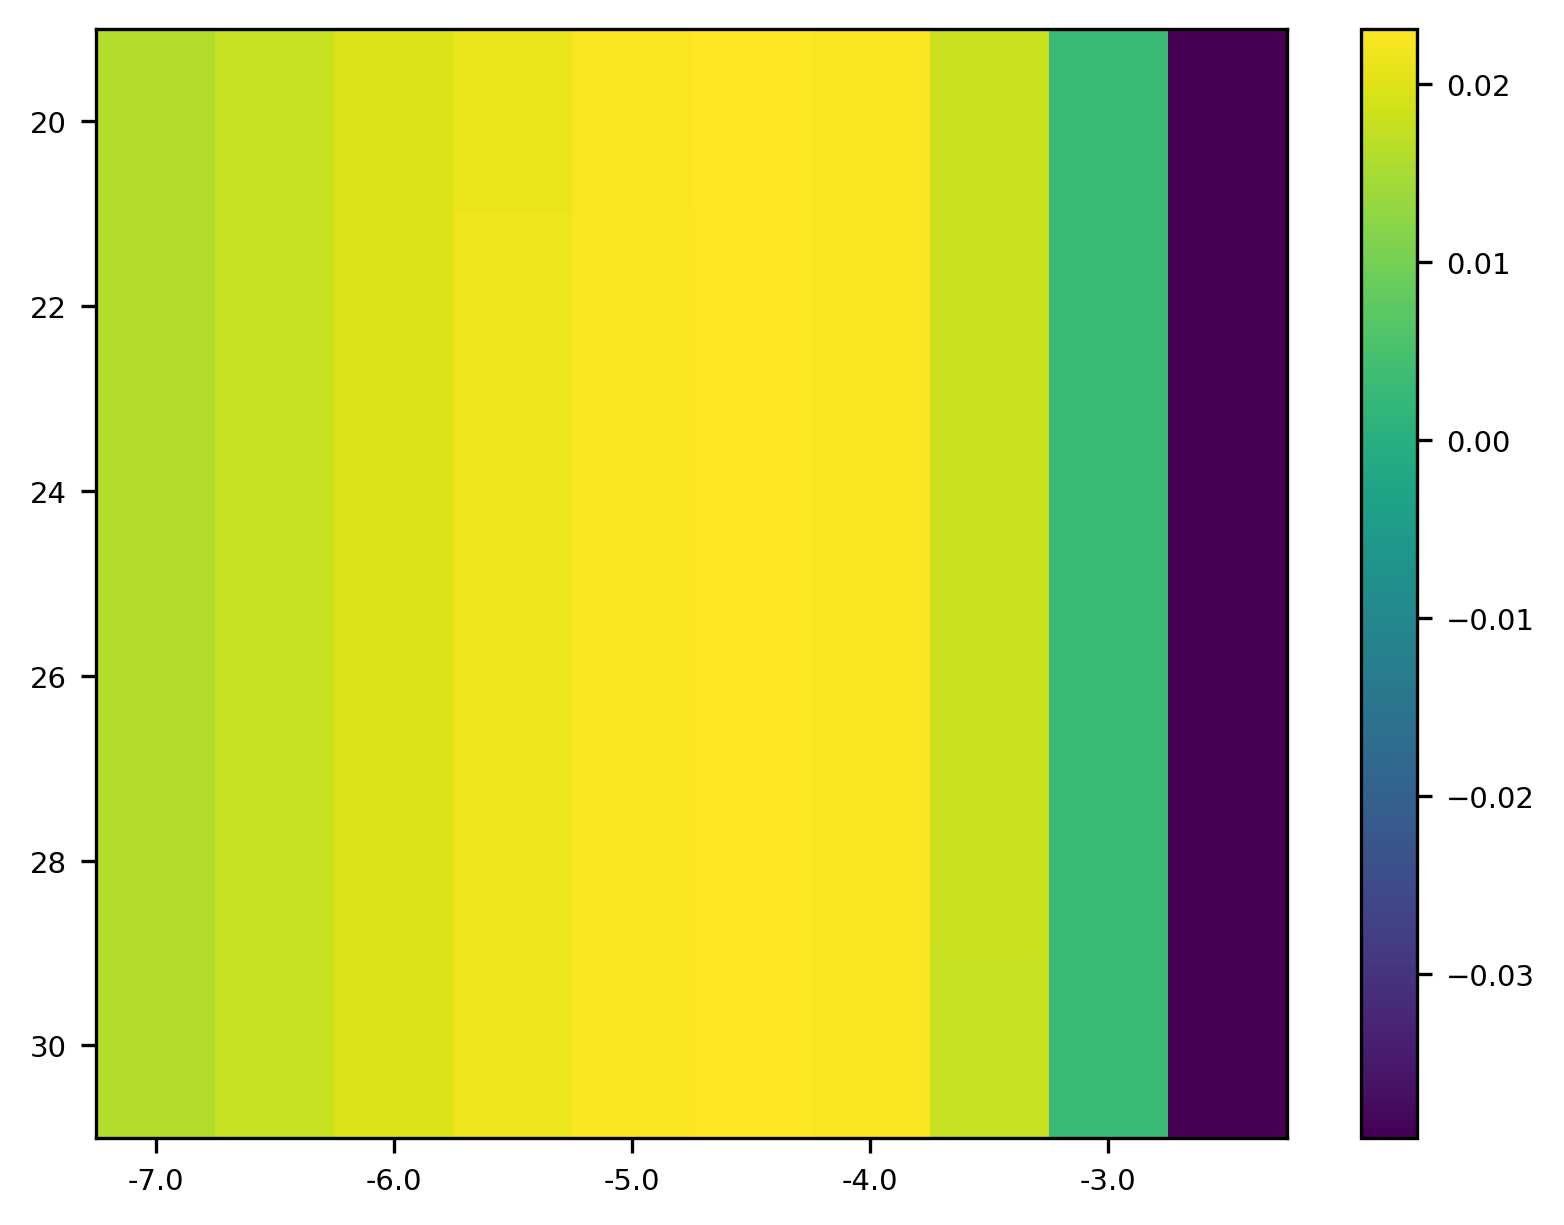

In [11]:
# find the kernel size based on fold 0

from scipy.stats import poisson
from tqdm import tqdm



def cobps_fold0(kernel_size, clip_value):
    kernel = np.exp(-np.linspace(-3,3,int(kernel_size))**2)
    kernel /= kernel.sum()
    concat_avg_rates = np.ones_like(concat_data)*np.nan
    for d in np.unique(dir_index):
        mask = dir_index == d
        masked_data = concat_data[mask]
        masked_rates = np.ones_like(masked_data)*np.nan
        fold_ids = np.arange(masked_data.shape[0]) % N_FOLDS
        for fold in [0]:
            test_mask = (fold_ids == fold)
            train_mask = (fold_ids != fold)
            fr = masked_data[train_mask].mean(0)
            # gauss smooth across time (axis=1)
            for i in range(masked_data.shape[1]):
                fr[...,i] = np.convolve(fr[...,i], kernel, mode='same')
            masked_rates[test_mask] = fr
            
        concat_avg_rates[mask] = masked_rates

    concat_avg_rates = np.clip(concat_avg_rates,clip_value,+np.inf)

    valid_mean_count = concat_data.mean(0).mean(0) # to get Hz -> x100
    base_LL = poisson.logpmf(concat_data, valid_mean_count)
    n_sp = concat_data.sum()

    valid_LL = poisson.logpmf(concat_data, concat_avg_rates)
    valid_co_bps = np.nansum(valid_LL - base_LL)/(n_sp * np.log(2))

    return valid_co_bps

# optimize kernel size and clip value to maximize co bps on fold 0
#use grid search
kernel_sizes = np.arange(20,31,2)
clip_values = np.logspace(-3,-1,10)
co_bps = np.zeros((len(kernel_sizes),len(clip_values)))
for i, kernel_size in tqdm(enumerate(kernel_sizes)):
    for j, clip_value in enumerate(clip_values):
        co_bps[i,j] = cobps_fold0(kernel_size, clip_value)

plt.imshow(co_bps,aspect='auto')
plt.xticks(np.arange(len(clip_values))[::2],np.round(np.log(clip_values[::2])))
plt.yticks(np.arange(len(kernel_sizes)),kernel_sizes)
plt.colorbar()

# find the best kernel size and clip value
best_kernel_size, best_clip_value = np.unravel_index(np.argmax(co_bps),co_bps.shape)
best_kernel_size, best_clip_value = kernel_sizes[best_kernel_size], clip_values[best_clip_value]
best_kernel_size, best_clip_value

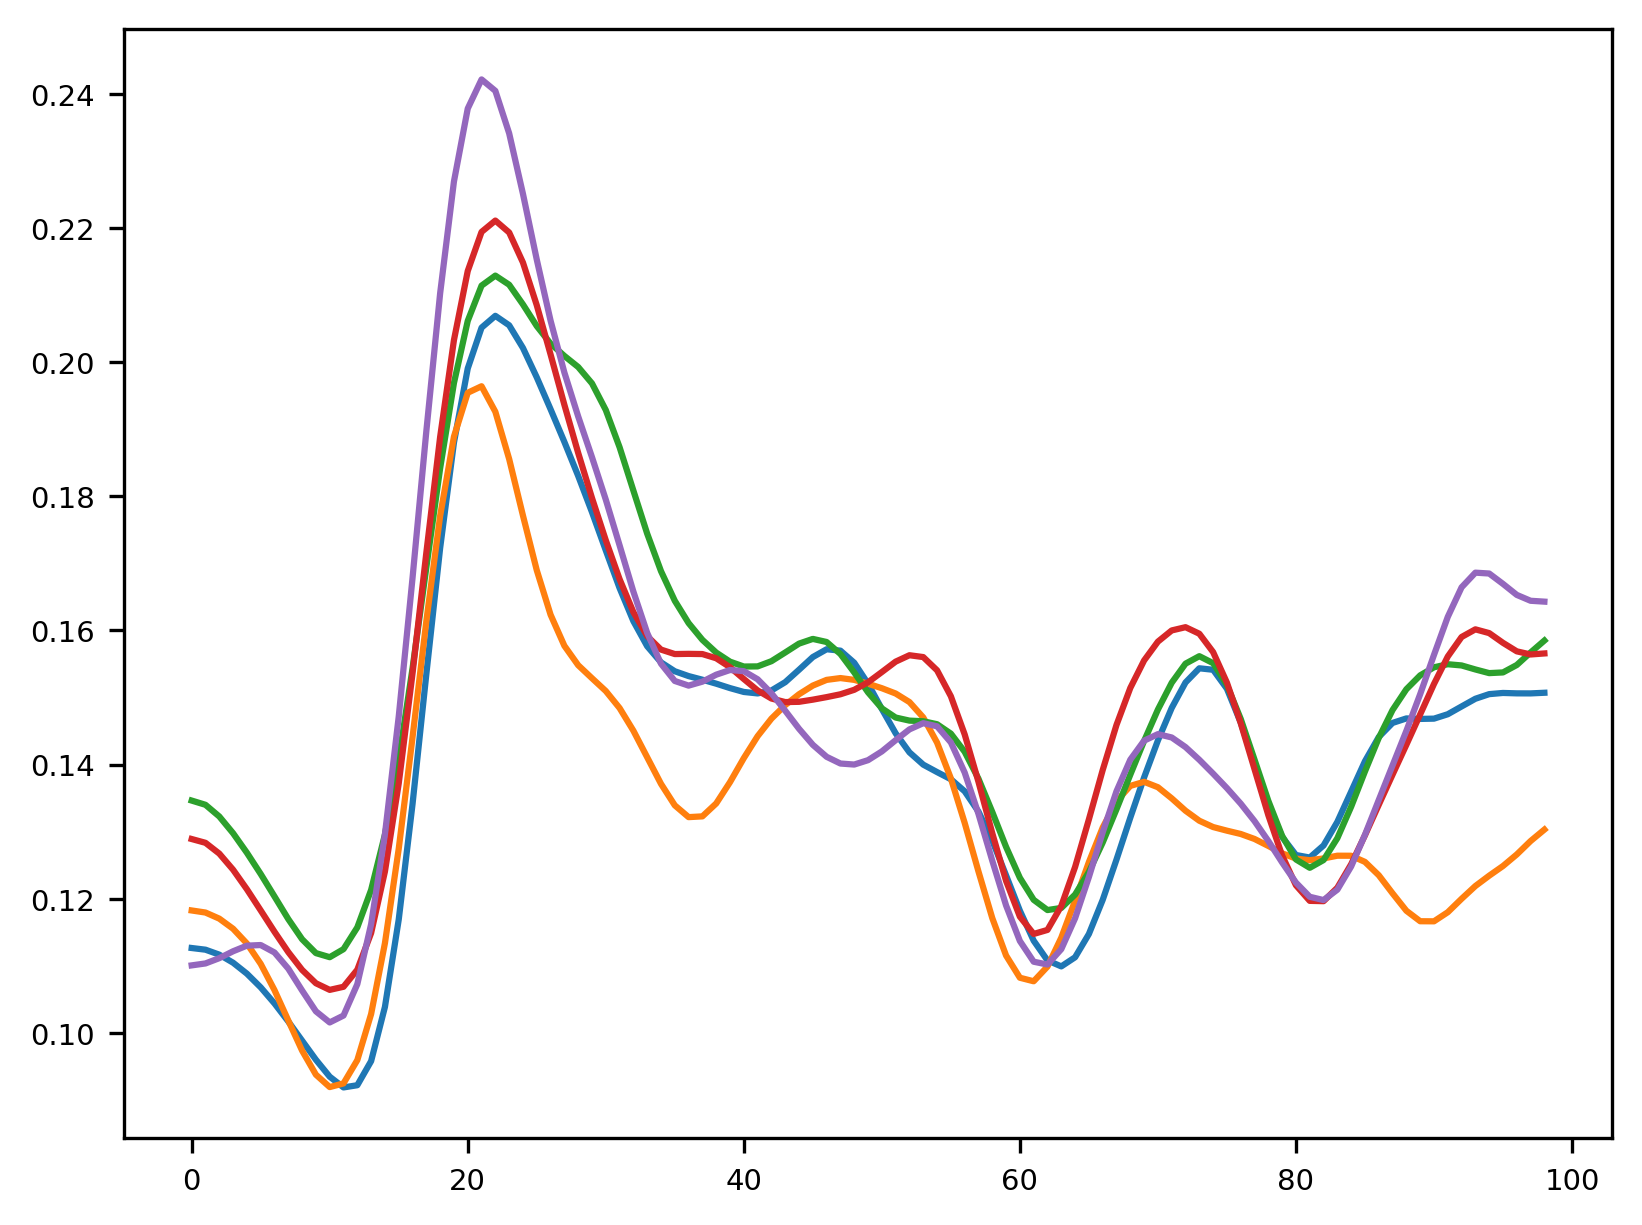

In [12]:
kernel = np.exp(-np.linspace(-3,3,best_kernel_size)**2)
kernel /= kernel.sum()
concat_avg_rates = np.ones_like(concat_data)*np.nan
for d in np.unique(dir_index):
    mask = dir_index == d
    masked_data = concat_data[mask]
    masked_rates = np.ones_like(masked_data)*np.nan
    fold_ids = np.arange(masked_data.shape[0]) % N_FOLDS
    for fold in range(N_FOLDS):
        test_mask = (fold_ids == fold)
        train_mask = (fold_ids != fold)
        fr = masked_data[train_mask].mean(0).astype('float64')
        # gauss smooth across time (axis=1)
        for i in range(masked_data.shape[1]):
            fr[...,i] = np.convolve(np.concatenate([fr[::-1,i],fr[:,i],fr[::-1,i]]), kernel, mode='same')[len(fr):2*len(fr)]
        masked_rates[test_mask] = fr
        if (d ==1):
            plt.plot(fr[...,1])
            # plt.plot(masked_data[test_mask].mean(0)[...,1])
    
    concat_avg_rates[mask] = masked_rates
    
assert np.all(~np.isnan(concat_avg_rates))
concat_avg_rates = np.clip(concat_avg_rates,best_clip_value,+np.inf)

In [13]:
valid_mean_count = concat_data.mean(0).mean(0) # to get Hz -> x100
base_LL = poisson.logpmf(concat_data, valid_mean_count)
n_sp = concat_data.sum()

valid_LL = {'CSAE': poisson.logpmf(concat_data, (bin_size_ms / 1000) * concat_rates[0]), 
            'BAND': poisson.logpmf(concat_data, (bin_size_ms / 1000) * concat_rates[1]),
            'CSAE_noci': poisson.logpmf(concat_data, (bin_size_ms / 1000) * concat_noci_rates[0]), 
            'BAND_noci': poisson.logpmf(concat_data, (bin_size_ms / 1000) * concat_noci_rates[1]),
            'avg': poisson.logpmf(concat_data, concat_avg_rates)}
valid_co_bps = {key: np.sum(valid_LL[key] - base_LL)/(n_sp * np.log(2)) for key in valid_LL.keys()}
valid_co_bps_per_neuron = {key: np.sum(valid_LL[key] - base_LL,axis=0).sum(0)/(n_sp * np.log(2)) for key in ['BAND','BAND_noci']}
valid_co_bps

{'CSAE': 0.21855593596707515,
 'BAND': 0.21532810005388864,
 'CSAE_noci': 0.2090967801172238,
 'BAND_noci': 0.1866235439084098,
 'avg': 0.1228174991329046}

In [14]:
delta_per_neuron = valid_co_bps_per_neuron['BAND'] - valid_co_bps_per_neuron['BAND_noci']
np.argsort(delta_per_neuron)[::-1]

array([102,  29,  35, 146,  27,  33, 205, 134,  41,   8,   7, 112,  28,
        62,  69, 173,   2, 172,   0, 109,  67,  55,  61,  12,  50, 174,
        64, 132, 157,  23,  40, 152,  38,  14,  26,  76,  57, 105,  47,
       185,   1, 162,  22,  44,  97,  17,  65,  92,   4,  66,  99,  34,
       108, 114,  93,  18,  37, 186, 164, 158,   3, 145, 113, 103,  51,
       161,  52,  49, 117, 201,   6, 190,  58, 166,   5,  20,  90, 106,
       136,  95,  85,   9, 176, 169, 168, 194,  10,  45, 141, 115, 142,
       127,  87, 140, 128, 206,  42, 171,  43, 167, 178,  59, 139, 125,
        46,  70,  89,  88, 202, 175,  31, 179, 196, 135, 156,  82, 148,
       129, 184,  36,  21,  16, 107, 153,  77, 100,  25, 111,  19, 160,
       116,  74, 187, 137,  98, 123,  91, 183,  81,  94,  53,  68, 104,
       133, 163, 191, 159,  80, 110, 182,  24,  15, 181,  96, 198,  13,
       121, 193, 170, 188, 138, 120, 151, 118,  32,  84,  83, 177,  60,
        48, 189, 199, 154, 144, 143,  11, 200, 192,  79, 195,  7

## calculate R2

In [15]:
beh_r2 = {key: 100*r2_score(concat_behaviors[i], concat_true_behavior) for i, key in enumerate(['CSAE','BAND'])}
beh_r2.update({key: 100*r2_score(concat_noci_behaviors[i], concat_true_behavior) for i, key in enumerate(['CSAE_noci','BAND_noci'])})
print(beh_r2)

{'CSAE': 79.81982144745012, 'BAND': 92.42350175926038, 'CSAE_noci': 76.3004735481265, 'BAND_noci': 76.00736273247358}


In [16]:
dir_index = get_target_ids(concat_target_direction)
beh_r2_uive = {key: 100*r2_UIVE(concat_behaviors[i], concat_true_behavior, dir_index) for i, key in enumerate(['CSAE','BAND'])}
beh_r2_uive.update({key: 100*r2_UIVE(concat_noci_behaviors[i], concat_true_behavior,dir_index) for i, key in enumerate(['CSAE_noci','BAND_noci'])})
print(beh_r2_uive)

{'CSAE': 13.881339735971803, 'BAND': 67.44213618553924, 'CSAE_noci': -0.9828467299001207, 'BAND_noci': -1.200097207285443}


In [17]:
beh_mse = {key: np.mean((concat_behaviors[i] - concat_true_behavior)**2) for i, key in enumerate(['CSAE','BAND'])}
beh_mse.update({key: np.mean((concat_noci_behaviors[i] - concat_true_behavior)**2) for i, key in enumerate(['CSAE_noci','BAND_noci'])})

targets = concat_true_behavior
num_conditions = len(np.unique(dir_index))
avg_vel = np.zeros_like(targets)
for d in range(num_conditions):
    avg_vel[dir_index==d] = np.mean(targets[dir_index==d], axis=0)
beh_mse.update({'avg_behavior': np.mean((avg_vel - concat_true_behavior)**2)})
beh_mse.update({'var': np.mean((concat_true_behavior)**2)})

print(beh_mse)

{'CSAE': 13.802734650655685, 'BAND': 5.163920723850438, 'CSAE_noci': 16.1540086201485, 'BAND_noci': 16.34269384407906, 'avg_behavior': 15.993487159906957, 'var': 68.38819545867645}


### prepare factor in ordered trials

In [18]:
factors_pull = concat_factors[model_id]
factors_noci_pull = concat_factors_noci[model_id]
ids_pull = concat_ids.copy()
epochs_pull = concat_epochs

n_BL = np.sum(epochs_pull==0)
n_AD = np.sum(epochs_pull==1)
n_WO = np.sum(epochs_pull==2)
n = n_BL + n_AD + n_WO

ids_pull[epochs_pull == 1] = ids_pull[epochs_pull == 1] + 500
ids_pull[epochs_pull == 2] = ids_pull[epochs_pull == 2] + 1000

assert np.all(np.diff(ids_pull) > 0), 'IDs are not sorted'


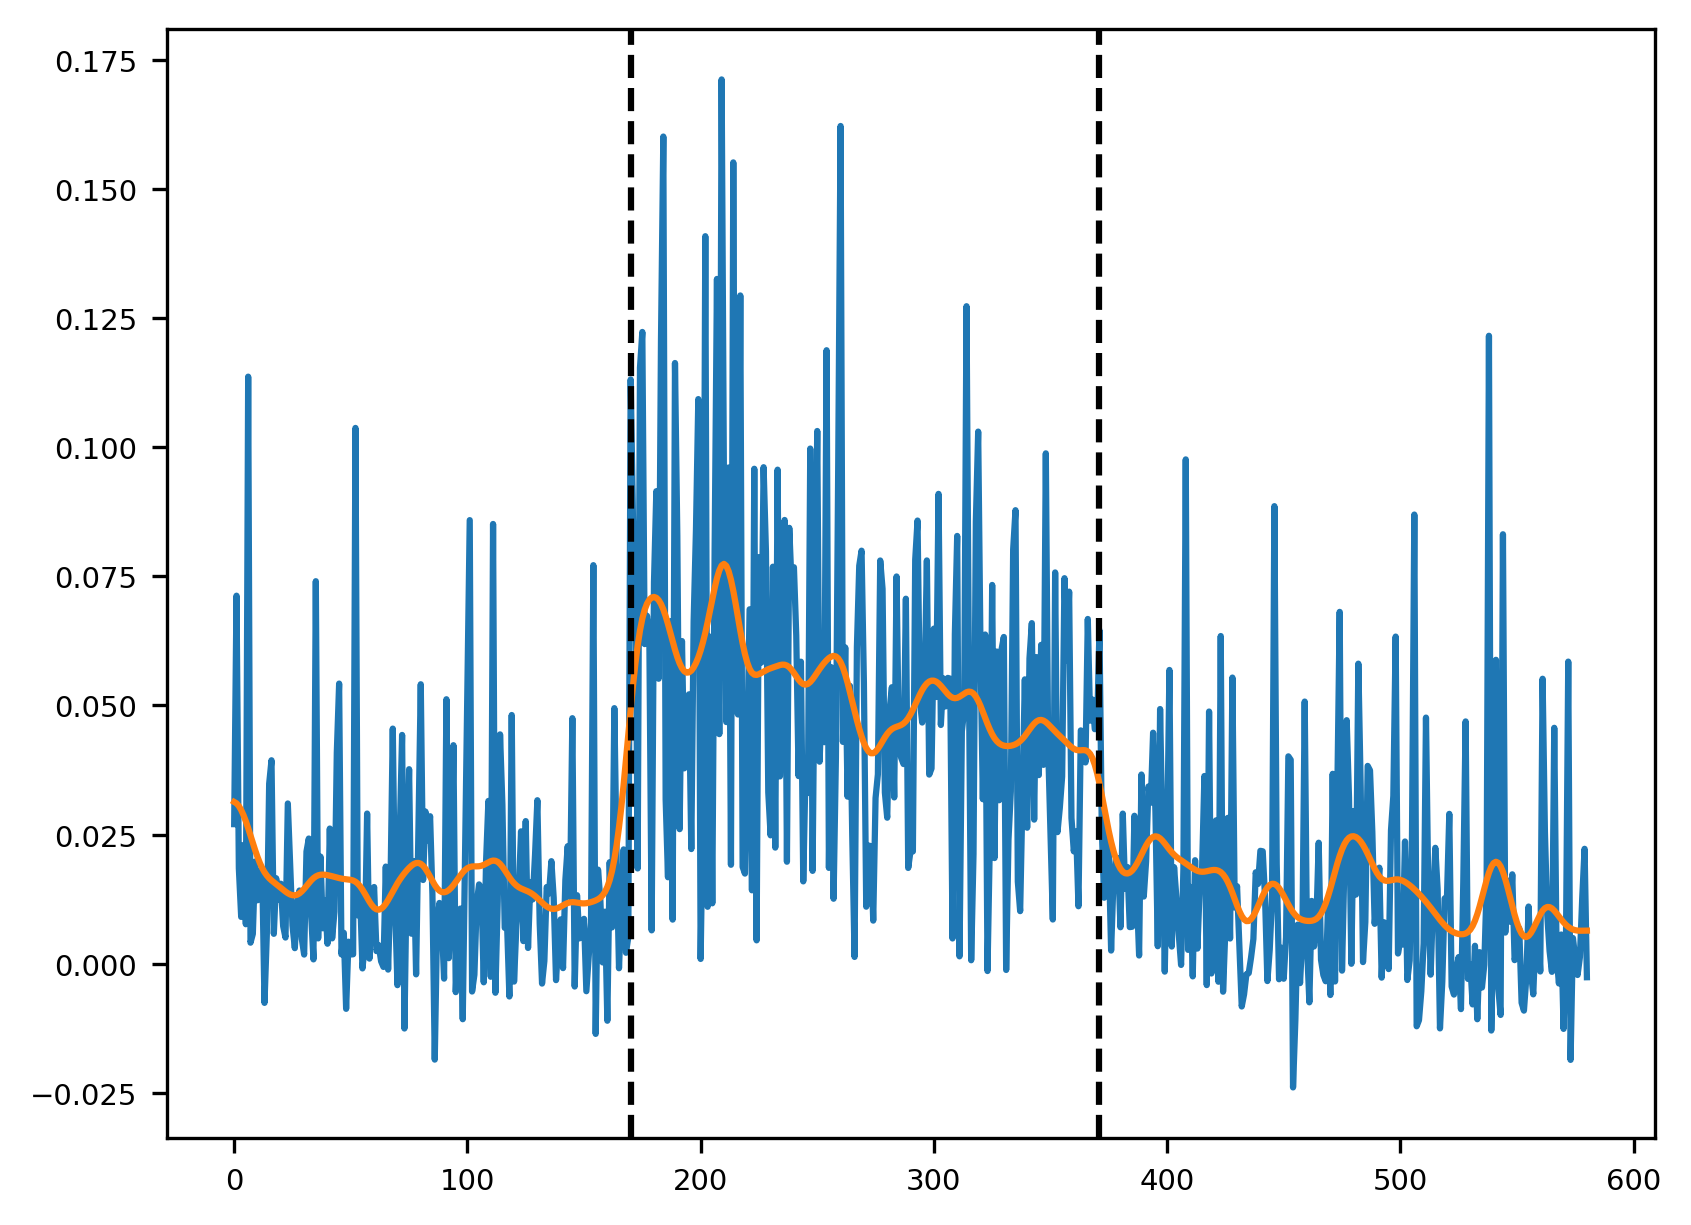

In [19]:
n_sp = concat_data.sum(1).sum(1)
data_pull = concat_data
base_LL_pull = poisson.logpmf(data_pull, data_pull.mean(0).mean(0))
cobps_pull = (poisson.logpmf(concat_data, (bin_size_ms / 1000) * concat_rates[model_id]) - base_LL_pull).sum(1).sum(1)/(n_sp * np.log(2)) 
cobps_noci_pull = (poisson.logpmf(concat_data,(bin_size_ms / 1000) * concat_noci_rates[model_id]) - base_LL_pull).sum(1).sum(1)/(n_sp * np.log(2))
plt.plot(cobps_pull- cobps_noci_pull)
# gaussian filter
from scipy.ndimage import gaussian_filter1d
plt.plot(gaussian_filter1d(cobps_pull - cobps_noci_pull, 5))
plt.axvline(np.sum(epochs_pull==0), color='k', linestyle='--')
plt.axvline(np.sum(epochs_pull==1) + np.sum(epochs_pull==0), color='k', linestyle='--')

In [20]:
dir_index = get_target_ids(concat_target_direction)
num_conditions = len(np.unique(dir_index))

targets, preds = concat_true_behavior, concat_behaviors[model_id]
avg_vel = [np.mean(targets[dir_index==d], axis=0) for d in range(num_conditions)]
total_var = [((targets[dir_index==d] - avg_vel[d])**2).sum(1).sum(1) for d in range(num_conditions)]
expl_var  = [((preds[dir_index==d] - targets[dir_index==d])**2).sum(1).sum(1) for d in range(num_conditions)] 


In [21]:
expl_var = np.mean((concat_behaviors[model_id] - concat_true_behavior)**2, axis=(1,2))
expl_var_noci = np.mean((concat_noci_behaviors[model_id] - concat_true_behavior)**2, axis=(1,2))
total_var = np.mean((concat_true_behavior)**2, axis=(1,2))
r2_trials = 100*(1 - expl_var / total_var) - 100*(1 - expl_var_noci / total_var)


In [22]:
mse_trials = np.mean((concat_behaviors[model_id] - concat_true_behavior)**2, axis=1).sum(-1)
mse_trials_noci = np.mean((concat_noci_behaviors[model_id] - concat_true_behavior)**2, axis=1).sum(-1)
concat_avg_behavior = np.ones_like(concat_true_behavior)*np.nan
for d in range(num_conditions):
    concat_avg_behavior[dir_index==d] = concat_true_behavior[dir_index==d].mean(0)
mse_trials_avg = np.mean((concat_noci_behaviors[model_id] - concat_true_behavior)**2, axis=1).sum(-1)
mse_trials_delta = mse_trials_avg - mse_trials
mse_trials_avg_delta = mse_trials_avg - mse_trials_noci

In [23]:
mse_dist_trials = np.mean((concat_behaviors[model_id] - concat_noci_behaviors[model_id])**2, axis=1).sum(-1)

### then plot the figure

In [24]:
def make_task_schematics(ax, x,y,r,aspect=1.,shown=np.ones(8)):

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # bbox = ax.get_window_extent().transformed(ax.get_figure().dpi_scale_trans.inverted())
    # aspect = bbox.width / bbox.height
    # print(aspect)

    # draw a circle around the center with 8 target directions
    theta = np.roll(np.linspace(0,2*np.pi,9)[:-1],3)
    x_t = x + r*np.cos(theta)
    y_t = y + r*np.sin(theta)*aspect

    for c, (s, xt, yt) in enumerate(zip(shown, x_t,y_t)):
        fill = {'facecolors': f'C{c}'} if s else {'facecolors': 'none'}
        ax.scatter(xlim[0] + (xlim[1] - xlim[0])*xt,
                    ylim[0] + (ylim[1] - ylim[0])*yt,
                    s=20,edgecolors=f'C{c}',linewidth=.5,
                    **fill)
    ax.scatter(xlim[0] + (xlim[1] - xlim[0]) * x,
                ylim[0] + (ylim[1] - ylim[0]) * y,
                s = 20, c='k', marker='+',linewidth=.5)

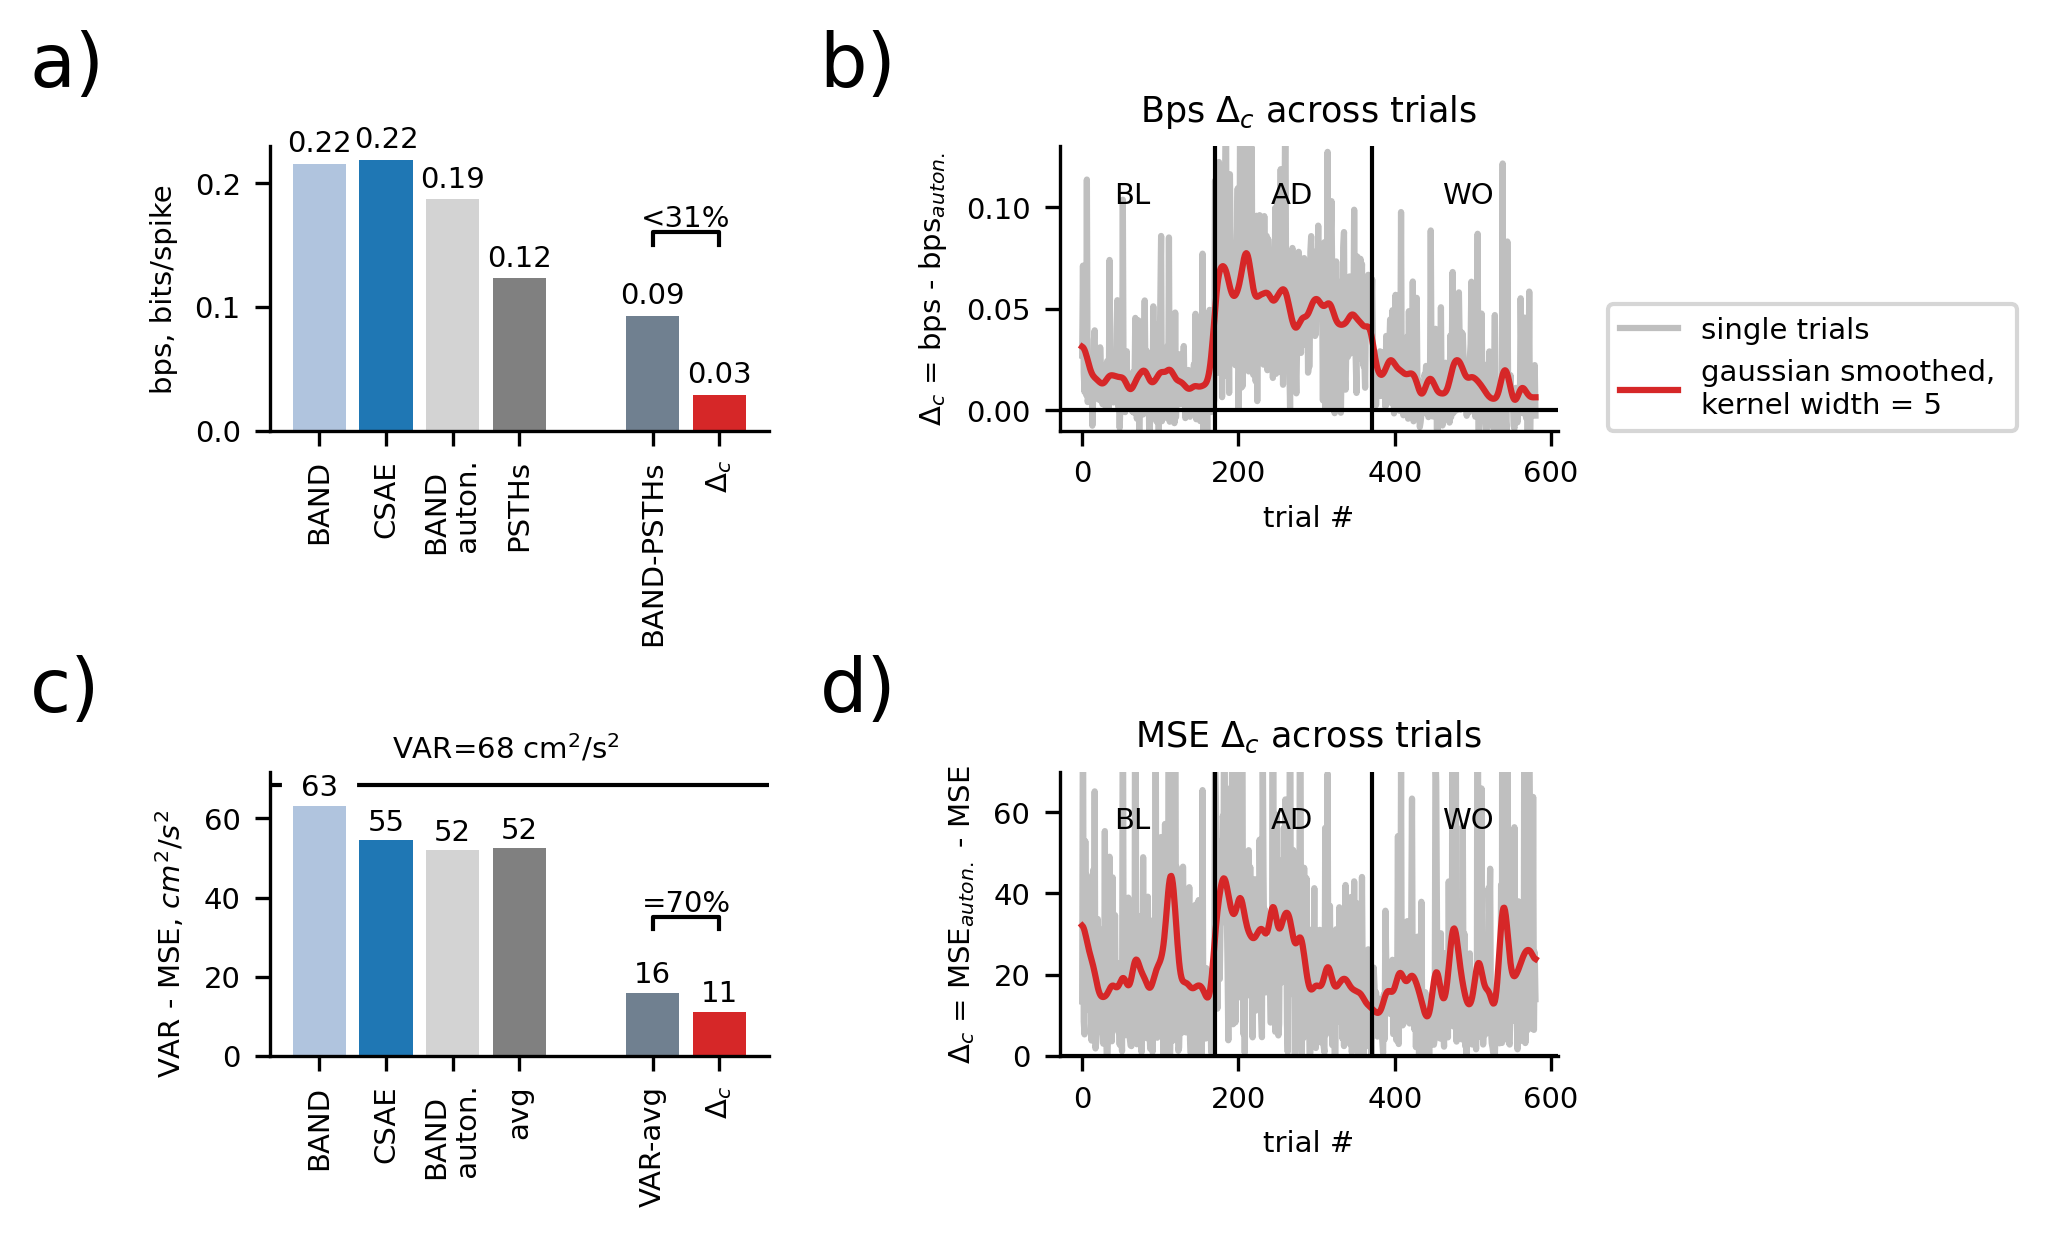

In [41]:
def bar_bracket(ax, index1, index2, h1, h2, text):

    bx = [index1, index1, index2, index2]
    by = [h1, h2, h2 , h1]
    ax.plot(bx, by, 'k-', lw=1)
    ax.text((index1 + index2) / 2, h2, text, ha='center', va='bottom')

    
layout = '''
ab.
cd.
'''

trial_kernel_w = 5 # kernel width for smoothing over trials
select = [2,6] # directions to plot

fig = plt.figure(figsize=(18*cm, 10*cm))
# blank = fig.add_subplot([0,0,1,1])
specs, gs = panel_specs(layout, fig=fig, gridspec_args={'left': 0.12, 'right': .98, 'bottom': 0.13, 'top': 0.9, 'hspace': 1.2, 'wspace': .7})
axes = {}

w_ratios = [1,1,.5]
h_ratios = [1,1]
gs.set_width_ratios(w_ratios)
gs.set_height_ratios(h_ratios)

for letter, spec in specs.items():
    axes[letter] = fig.add_subplot(spec)
    label_panel(axes[letter], letter, postfix=')')

for k in axes.keys():
    axes[k].spines['right'].set_visible(False)
    axes[k].spines['top'].set_visible(False)
trial_kernel_w = 5 # kernel width for smoothing over trials
# Panel A: plot oscillating factor variability
values = [valid_co_bps[mn], valid_co_bps['CSAE'], valid_co_bps[f'{mn}_noci'], 
                valid_co_bps['avg'], 
                0,
                valid_co_bps[mn] - valid_co_bps['avg'],
                valid_co_bps[mn] - valid_co_bps[f'{mn}_noci']]
axes['a'].bar([mn, 'CSAE', f'{mn}\n auton.',
                'PSTHs','','BAND-PSTHs', r'$\Delta_c$'], 
               values,
               color=['lightsteelblue','C0', 'lightgrey','grey','grey','slategrey','C3'])
xticks = [0,1,2,3,5,6]
axes['a'].set_xticks(xticks)
axes['a'].set_xticklabels(axes['a'].get_xticklabels(), rotation=90)
axes['a'].set_ylabel('bps, bits/spike')
for i, v in enumerate(values):
    if i in xticks:
        axes['a'].text(i, v+0.01, f"{v:.2f}", ha='center')

p = int(np.round(100*(valid_co_bps[mn] - valid_co_bps[f'{mn}_noci'])/(valid_co_bps[mn] - valid_co_bps['avg'])))
bar_bracket(axes['a'], 5, 6, 0.15,0.16, f'<{p:d}%')

axes['b'].plot(cobps_pull- cobps_noci_pull,alpha=0.5,c='grey',label='single trials')
axes['b'].plot(gaussian_filter1d(cobps_pull - cobps_noci_pull, trial_kernel_w),c='C3', label=f'gaussian smoothed, \nkernel width = {trial_kernel_w:d}')
n_BL = np.sum(epochs_pull==0)
n_AD = np.sum(epochs_pull==1)
n_WO = np.sum(epochs_pull==2)
n = n_BL + n_AD + n_WO
axes['b'].axvline(n_BL, color='k', linewidth=1)
axes['b'].axvline(n_BL+n_AD, color='k', linewidth=1)
axes['b'].axhline(0, color='k', linewidth=1)
axes['b'].text(0.5 * n_BL / n, 0.8, 'BL', transform=axes['b'].transAxes, ha='center')
axes['b'].text((n_BL + 0.5*n_AD) / n, 0.8, 'AD', transform=axes['b'].transAxes, ha='center')
axes['b'].text((n_BL + n_AD + 0.5*n_WO) / n, 0.8, 'WO', transform=axes['b'].transAxes, ha='center')
axes['b'].set_xlabel('trial #')
axes['b'].set_ylabel(r'$\Delta_c$ = bps - bps$_{auton.}$')
axes['b'].set_title(r'Bps $\Delta_c$ across trials')
axes['b'].set_ylim([-0.01,0.13])
axes['b'].legend(loc=(1.1,0))

# Panel c: 
delta = beh_mse[f'{mn}_noci'] - beh_mse[mn]
values = [beh_mse['var'] - beh_mse[mn],
                beh_mse['var'] - beh_mse['CSAE'],
                beh_mse['var'] - beh_mse[f'{mn}_noci'],
                beh_mse['var'] - beh_mse['avg_behavior'],
                0,
                beh_mse['avg_behavior'],
                delta]
axes['c'].bar([mn, 'CSAE', f'{mn}\n auton.',
                'avg','','VAR-avg',r'$\Delta_c$'], 
               values,
                color=['lightsteelblue','C0', 'lightgrey', 'grey','grey','slategrey','C3'], zorder=2)
axes['c'].set_xticks(xticks)
axes['c'].set_xticklabels(axes['c'].get_xticklabels(), rotation=90)
axes['c'].set_ylabel(r'VAR - MSE, $cm^2/s^2$       ')
for i, v in enumerate(values):
    # on white background
    if i in xticks:
        axes['c'].text(i, v+2.5, f"{v:.0f}", ha='center', backgroundcolor='w', zorder=1) # zorder is important to not obstruct part of the bar
# axes['D0'].set_ylim([-10,15])
axes['c'].axhline(beh_mse['var'], color='k', linewidth=1, zorder=0)
axes['c'].text(4.5, 1.1*beh_mse['var'], f"VAR={beh_mse['var']:.0f} "+r"cm$^2$/s$^2$", ha='right')

p = int(np.round(100*delta/beh_mse['avg_behavior']))
bar_bracket(axes['c'], 5, 6, 32,35, f'={p:d}%')


axes['d'].plot(mse_trials_delta,alpha=0.5,c='grey')
axes['d'].plot(gaussian_filter1d(mse_trials_delta, trial_kernel_w),c='C3')
n_BL = np.sum(epochs_pull==0)
n_AD = np.sum(epochs_pull==1)
n_WO = np.sum(epochs_pull==2)
n = n_BL + n_AD + n_WO
axes['d'].axvline(n_BL, color='k', linewidth=1)
axes['d'].axvline(n_BL+n_AD, color='k', linewidth=1)
axes['d'].axhline(0, color='k', linewidth=1)
axes['d'].text(0.5 * n_BL / n, 0.8, 'BL', transform=axes['d'].transAxes, ha='center')
axes['d'].text((n_BL + 0.5*n_AD) / n, 0.8, 'AD', transform=axes['d'].transAxes, ha='center')
axes['d'].text((n_BL + n_AD + 0.5*n_WO) / n, 0.8, 'WO', transform=axes['d'].transAxes, ha='center')
axes['d'].set_xlabel('trial #')
axes['d'].set_ylabel(r'$\Delta_c$ = MSE$_{auton.}$ - MSE')
axes['d'].set_title(r'MSE $\Delta_c$ across trials')
axes['d'].set_ylim([0,70])

plt.subplots_adjust(hspace=0.6)
# plt.tight_layout()
plt.savefig(f"figs/fig5_{dataset_name}_{model_name}.pdf")   
plt.savefig(f"figs/fig5_{dataset_name}_{model_name}.png")

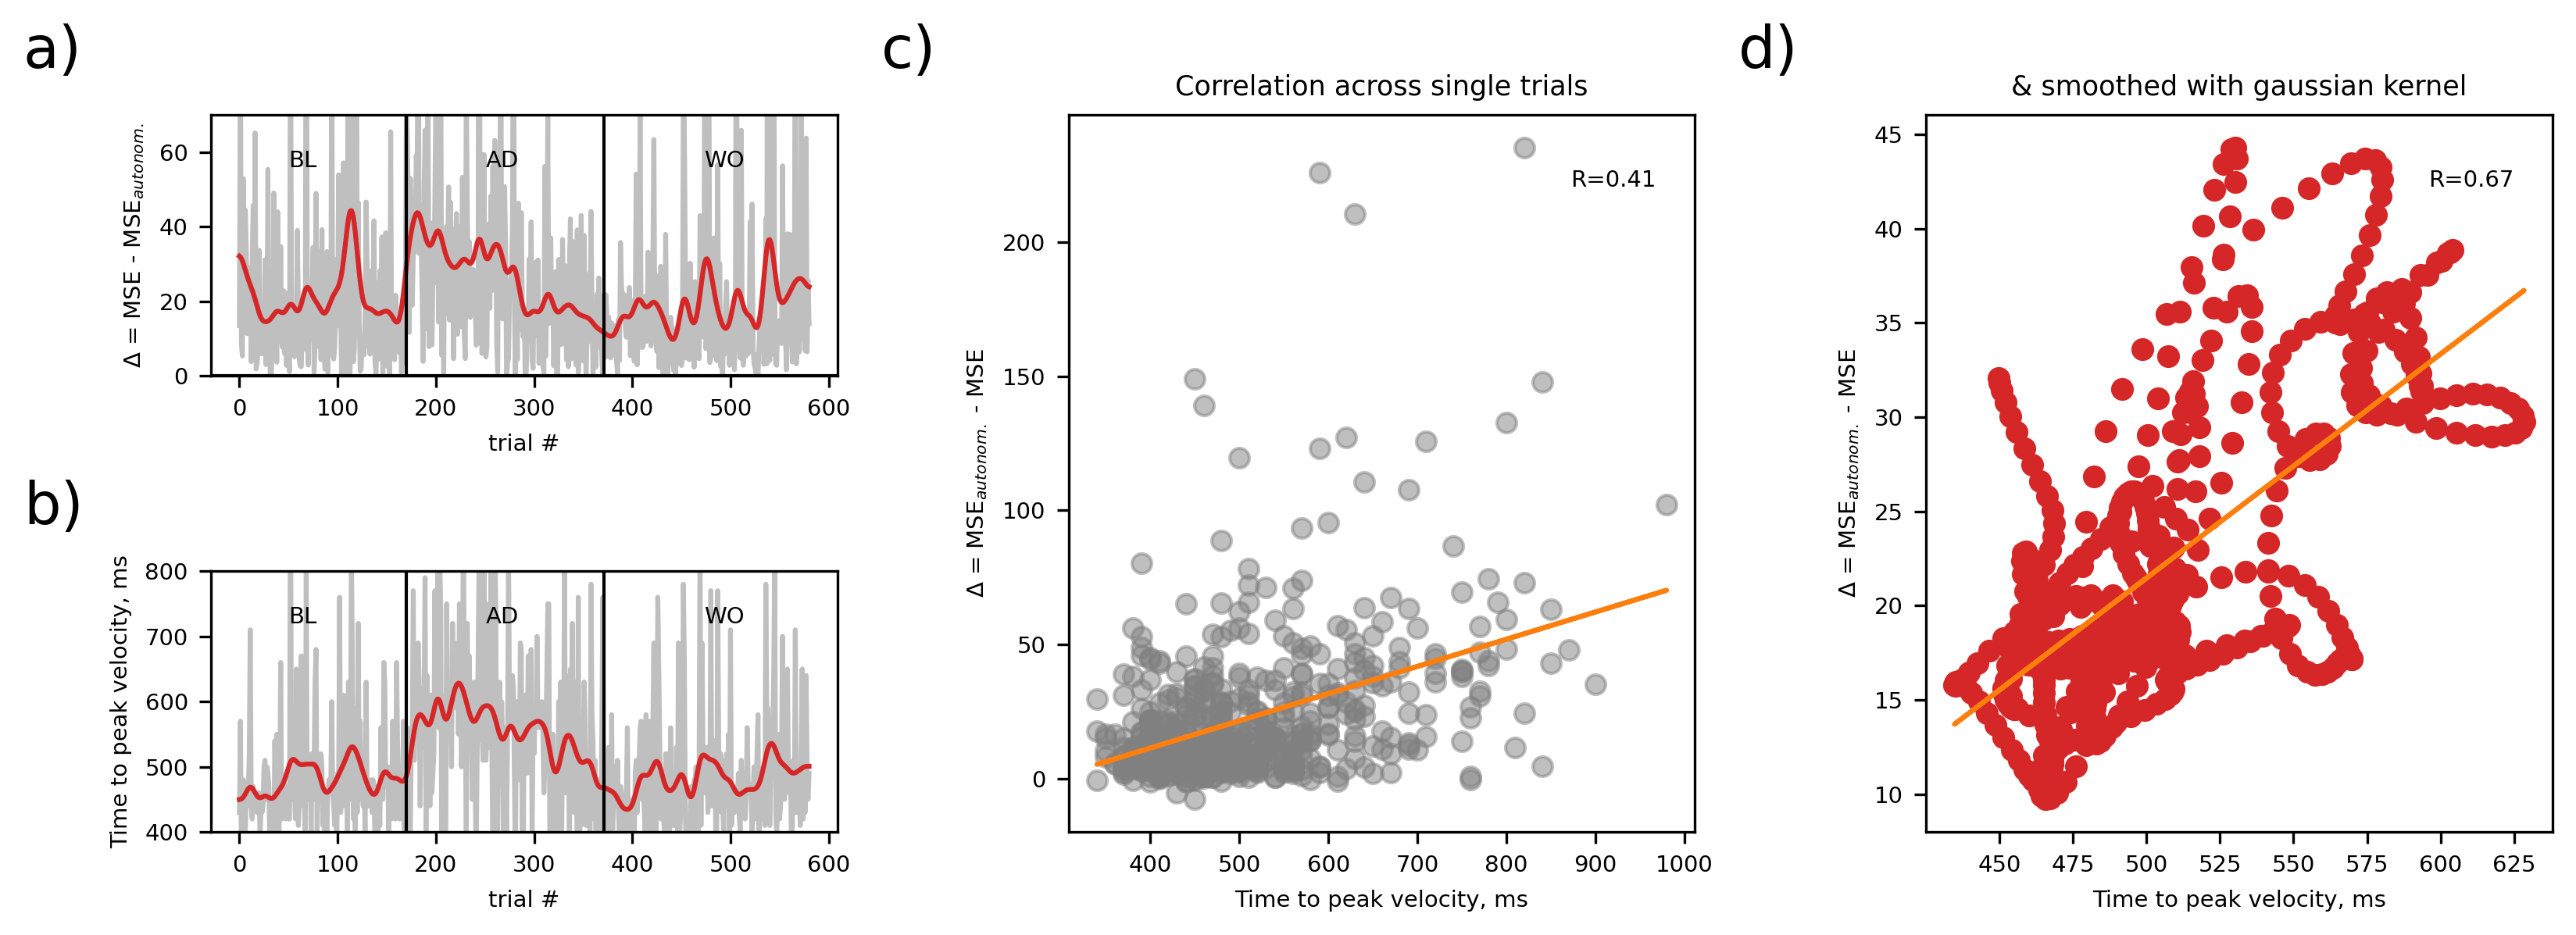

In [26]:
layout = '''
acd
bcd
'''

fig = plt.figure(figsize=(11, 4))
# blank = fig.add_subplot([0,0,1,1])
axes, spec = panels(layout, fig=fig)

label_panels(axes,postfix=')')

# plot reaction time
vel = np.linalg.norm(concat_true_behavior,axis=-1)
max_vel_t = np.argmax(vel,-1)
# max_vel_t = max_vel_t - max_vel_t.mean()

axes['a'].plot(mse_trials_delta,alpha=0.5,c='grey')
axes['a'].plot(gaussian_filter1d(mse_trials_delta, trial_kernel_w),c='C3')
axes['a'].set_ylabel(r'$\Delta$ = MSE - MSE$_{autonom.}$')
axes['a'].set_ylim([0,70])

max_vel_t_ms = max_vel_t.astype('float')*10

axes['b'].plot(max_vel_t_ms,c='grey', alpha=0.5)
axes['b'].plot(gaussian_filter1d(max_vel_t_ms, trial_kernel_w),c='C3')
axes['b'].set_ylabel(r'Time to peak velocity, ms')
axes['b'].set_ylim([400,800])

for ax in [axes['a'],axes['b']]:
    ax.axvline(n_BL, color='k', linewidth=1)
    ax.axvline(n_BL+n_AD, color='k', linewidth=1)
    ax.axhline(0, color='k', linewidth=1)
    ax.text(0.5 * n_BL / n, 0.8, 'BL', transform=ax.transAxes, ha='center')
    ax.text((n_BL + 0.5*n_AD) / n, 0.8, 'AD', transform=ax.transAxes, ha='center')
    ax.text((n_BL + n_AD + 0.5*n_WO) / n, 0.8, 'WO', transform=ax.transAxes, ha='center')
    ax.set_xlabel('trial #')


axes['c'].scatter(max_vel_t_ms, mse_trials_delta, c='grey', alpha=0.5)
axes['c'].set_xlabel('Time to peak velocity, ms')
axes['c'].set_ylabel(r'$\Delta$ = MSE$_{autonom.}$ - MSE')
axes['c'].set_title('Correlation across single trials')
# add trend and correlation
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(max_vel_t_ms, mse_trials_delta)
axes['c'].plot(max_vel_t_ms, slope*max_vel_t_ms + intercept, c='C1')
axes['c'].text(0.87,0.9,f"R={r_value:.2f}",transform=axes['c'].transAxes,ha='center')

axes['d'].scatter(gaussian_filter1d(max_vel_t_ms, trial_kernel_w), gaussian_filter1d(mse_trials_delta, trial_kernel_w), c='C3')
axes['d'].set_xlabel('Time to peak velocity, ms')
axes['d'].set_ylabel(r'$\Delta$ = MSE$_{autonom.}$ - MSE')
axes['d'].set_title(f'& smoothed with gaussian kernel')
slope, intercept, r_value, p_value, std_err = linregress(gaussian_filter1d(max_vel_t_ms, trial_kernel_w), gaussian_filter1d(mse_trials_delta, trial_kernel_w))
axes['d'].plot(gaussian_filter1d(max_vel_t_ms, trial_kernel_w), slope*gaussian_filter1d(max_vel_t_ms, trial_kernel_w) + intercept, c='C1')
axes['d'].text(0.87,0.9,f"R={r_value:.2f}",transform=axes['d'].transAxes,ha='center')

plt.tight_layout()

plt.savefig(f"figs/fig5_suppl_{dataset_name}_{model_name}.pdf")   
plt.savefig(f"figs/fig5_suppl_{dataset_name}_{model_name}.png")

In [ ]:
def get_chance_level_correlation(x,y):
    r_values = []
    for i in range(100):
        np.random.shuffle(x)
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        r_values.append(r_value)
    r_values = np.array(r_values)
    return np.percentile(r_values,[95])

print(get_chance_level_correlation(max_vel_t_ms, mse_trials_delta))
print(get_chance_level_correlation(gaussian_filter1d(max_vel_t_ms, trial_kernel_w), gaussian_filter1d(mse_trials_delta, trial_kernel_w)))

[0.07041022]
[0.05995601]


## finally, pull raw data to do Fourier analysis on movement-aligned data
Note that Fig3 has Fourier analysis on data aligned with the end of the trial. This preserved the most of the oscillations.
In principle, they are supposed to be the same. But trials have different intervals between target / go cue / movement, so some trials with short intervals are excluded. A few excluded trials (~5) are different between trial end aligned (Fig 3) and movement aligned (Fig 4).

In [ ]:

from plot_helpers import plot_fourier_last_sessions
import pyaldata

raw_data_dir = (
    "/disk/scratch/nkudryas/motor_cortex/perich_2018_binned/"
)

start_key = "idx_movement_on" # this - 25 - 1
shortest_trial = 99

# load all velocities for all sessions
Vel, Epoch = {}, {}
idx_go_cue, idx_movement_on, idx_peak_speed, idx_trial_end = {}, {}, {}, {}
experiment = "Chewie_CO_FF_2016-10-07.mat"
for spike_data_dir in [experiment]:
    pd_data = pyaldata.io.mat2dataframe(
        path=raw_data_dir + spike_data_dir, shift_idx_fields=True
    )

    # trials must be successful to be included
    successful_trials = pd_data.loc[(pd_data.result == "R")]

    # exclude bad trials
    behaviours = np.asarray(
        [
            d['vel'][d[start_key] -26 : d[start_key] -26 + shortest_trial, :]
            for i, d in successful_trials.iterrows()
        ]
    )
    trials_to_exclude = np.unique(np.where(np.abs(behaviours) > 100)[0])
    trial_mask = np.arange(behaviours.shape[0])
    trial_mask = np.delete(trial_mask,trials_to_exclude)
    print('Exclude trials with bad velocity: ',trials_to_exclude)
    # EXCLUDE
    selected_trials = successful_trials.iloc[trial_mask]

    
    Vel[spike_data_dir] = np.asarray(
            [
                d[f'vel'][d[start_key] - 26 : d[start_key] - 26 + shortest_trial, :]
                for _, d in selected_trials.iterrows()
            ]
        )
    
    print(Vel[spike_data_dir].shape)

    # epoch (BL/AD/WO) for each trial
    Epoch[spike_data_dir] = np.asarray(
            [
                d['epoch']
                for _, d in selected_trials.iterrows()
            ]
        )
    

trials, fourier = plot_fourier_last_sessions(ax, monkey='C', spike_data_dir=experiment, 
                                             vel=Vel, epoch=Epoch, plot='top_freq', 
                                             peak_freq = 5, color='C3')

FileNotFoundError: [Errno 2] No such file or directory: '/disk/scratch/nkudryas/motor_cortex/perich_2018_binned/Chewie_CO_FF_2016-10-07.mat'

(581,) (581,)


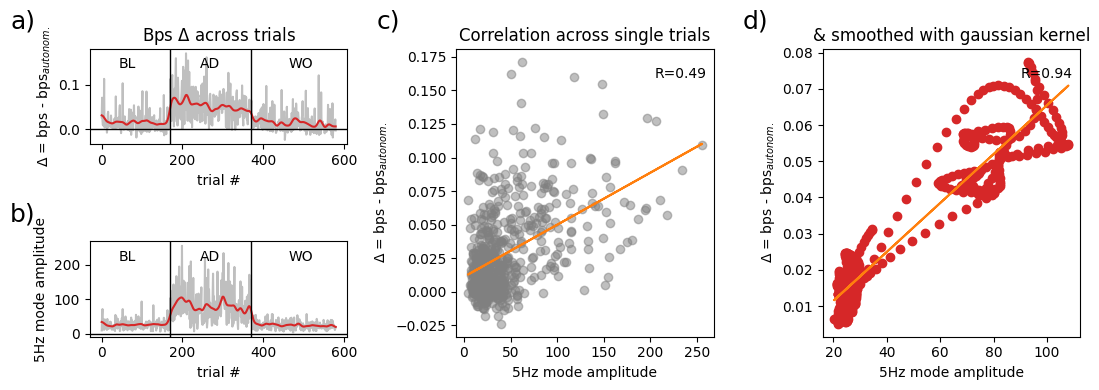

: 

In [ ]:
layout = '''
acd
bcd
'''

fig = plt.figure(figsize=(11, 4))
# blank = fig.add_subplot([0,0,1,1])
axes, spec = panels(layout, fig=fig)

label_panels(axes,postfix=')')

# plot reaction time
vel = np.linalg.norm(concat_true_behavior,axis=-1)
max_vel_t = np.argmax(vel,-1)
# max_vel_t = max_vel_t - max_vel_t.mean()

# bps
bps_delta = cobps_pull- cobps_noci_pull
axes['a'].plot(bps_delta,alpha=0.5,c='grey')
axes['a'].plot(gaussian_filter1d(bps_delta, trial_kernel_w),c='C3')
axes['a'].set_ylabel(r'$\Delta$ = bps - bps$_{autonom.}$')
axes['a'].set_title(r'Bps $\Delta$ across trials')

# 5Hz fourier mode load from data/fig5_suppl_fourier_over_trials.npy
axes['b'].plot(trials, fourier,alpha=0.5,c='grey')
axes['b'].plot(trials, gaussian_filter1d(fourier, trial_kernel_w),c='C3')
axes['b'].set_ylabel(r'5Hz mode amplitude')
# axes['b'].set_ylim([400,800])

print(bps_delta.shape, fourier.shape)

for ax in [axes['a'],axes['b']]:
    ax.axvline(n_BL, color='k', linewidth=1)
    ax.axvline(n_BL+n_AD, color='k', linewidth=1)
    ax.axhline(0, color='k', linewidth=1)
    ax.text(0.5 * n_BL / n, 0.8, 'BL', transform=ax.transAxes, ha='center')
    ax.text((n_BL + 0.5*n_AD) / n, 0.8, 'AD', transform=ax.transAxes, ha='center')
    ax.text((n_BL + n_AD + 0.5*n_WO) / n, 0.8, 'WO', transform=ax.transAxes, ha='center')
    ax.set_xlabel('trial #')


axes['c'].scatter(fourier, bps_delta, c='grey', alpha=0.5)
axes['c'].set_xlabel('5Hz mode amplitude')
axes['c'].set_ylabel(r'$\Delta$ = bps - bps$_{autonom.}$')
axes['c'].set_title('Correlation across single trials')
# add trend and correlation
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(fourier, bps_delta)
axes['c'].plot(fourier, slope*fourier + intercept, c='C1')
axes['c'].text(0.87,0.9,f"R={r_value:.2f}",transform=axes['c'].transAxes,ha='center')

axes['d'].scatter(gaussian_filter1d(fourier, trial_kernel_w), gaussian_filter1d(bps_delta, trial_kernel_w), c='C3')
axes['d'].set_xlabel('5Hz mode amplitude')
axes['d'].set_ylabel(r'$\Delta$ = bps - bps$_{autonom.}$')
axes['d'].set_title(f'& smoothed with gaussian kernel')
slope, intercept, r_value, p_value, std_err = linregress(gaussian_filter1d(fourier, trial_kernel_w), gaussian_filter1d(bps_delta, trial_kernel_w))
axes['d'].plot(gaussian_filter1d(fourier, trial_kernel_w), slope*gaussian_filter1d(fourier, trial_kernel_w) + intercept, c='C1')
axes['d'].text(0.87,0.9,f"R={r_value:.2f}",transform=axes['d'].transAxes,ha='center')

plt.tight_layout()

plt.savefig(f"figs/fig5_suppl_neuro_{dataset_name}_{model_name}.pdf")   
plt.savefig(f"figs/fig5_suppl_neuro_{dataset_name}_{model_name}.png")

In [ ]:
print(get_chance_level_correlation(fourier, bps_delta))
print(get_chance_level_correlation(gaussian_filter1d(fourier, trial_kernel_w), gaussian_filter1d(bps_delta, trial_kernel_w)))

[0.0708137]
[0.0774605]


: 

: 